In [17]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Charger le dataset Food-101 (train uniquement)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Récupérer les noms des classes
class_names = info.features['label'].names[:10]

# Filtrer le dataset pour ne garder que les 10 premières classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Diviser en train/validation (80% - 20%)
train_split = 0.8
dataset_size = sum(1 for _ in filtered_dataset)
train_size = int(train_split * dataset_size)

train_ds = filtered_dataset.take(train_size)
val_ds = filtered_dataset.skip(train_size)

# Fonction de prétraitement des images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalisation [0,1]
    return image, label

# Appliquer prétraitement
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Batch et préfetch des données
batch_size = 128
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#mixedprecision training
mixed_precision.set_global_policy('mixed_float16')

In [19]:
# Cnn model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation="relu", kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(len(class_names), activation="softmax", dtype='float32')  # dtype='float32' pour éviter erreurs Mixed Precision
])

In [20]:
# model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
# Display the model structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 718,378 (2.74 MB)

 Trainable params: 715,434 (2.73 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [22]:
# Callbacks to get a better training
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training of the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    callbacks=[lr_scheduler,early_stopping ]
)

Epoch 1/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 765ms/step - accuracy: 0.2318 - loss: 2.4905 - val_accuracy: 0.1340 - val_loss: 2.8044 - learning_rate: 0.0010
Epoch 2/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 528ms/step - accuracy: 0.3413 - loss: 1.9754 - val_accuracy: 0.1400 - val_loss: 3.5931 - learning_rate: 0.0010
Epoch 3/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 536ms/step - accuracy: 0.3937 - loss: 1.7533 - val_accuracy: 0.1093 - val_loss: 3.4948 - learning_rate: 0.0010
Epoch 4/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4328 - loss: 1.6452
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 528ms/step - accuracy: 0.4329 - loss: 1.6447 - val_accuracy: 0.1560 - val_loss: 3.4021 - learning_rate: 0.0010
Epoch 5/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 529ms/step - accuracy: 0.4773 - loss: 1.4908 - val_accuracy: 0.1073 - val_loss: 3.1229 - learning_rate: 5.0000e-04
Epoch 6/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 530ms/step - accuracy: 0.5146 - loss: 

In [23]:
# Evaluate the model on the validation dataset
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.1344 - loss: 2.8266

Validation Accuracy: 13.40%

Validation Loss: 2.8044


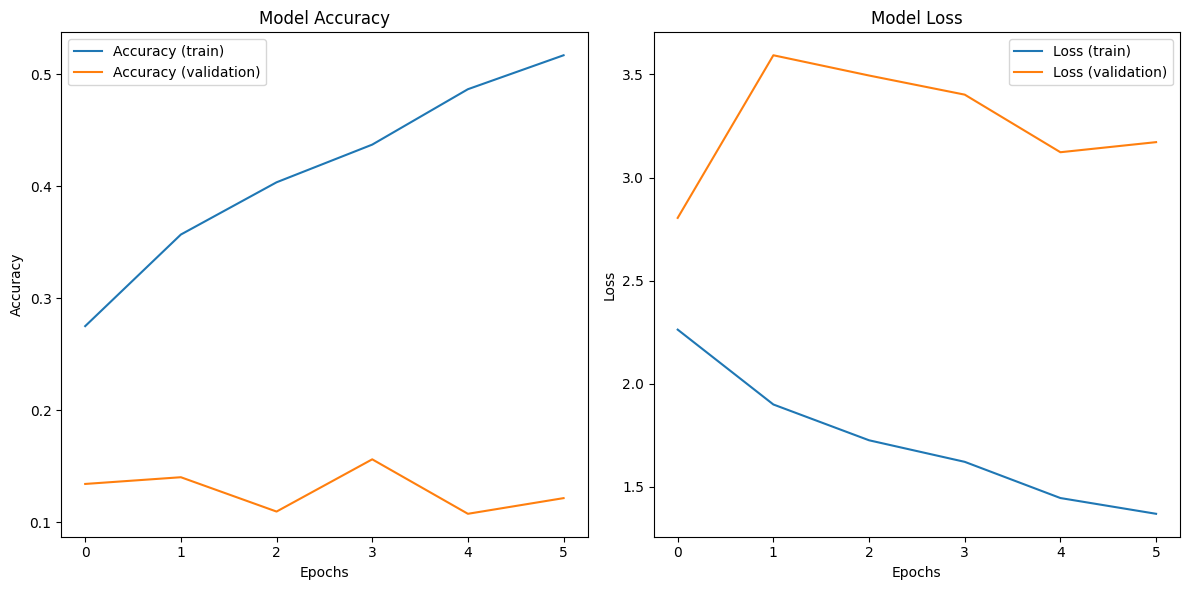

In [24]:
import matplotlib.pyplot as plt
# Plots of loss and accuracy
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(12, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy (train)')
plt.plot(val_acc, label='Accuracy (validation)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss (train)')
plt.plot(val_loss, label='Loss (validation)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.0000    0.0000    0.0000       152
   baby_back_ribs     0.0000    0.0000    0.0000       135
          baklava     0.0898    0.4348    0.1489       138
   beef_carpaccio     0.0000    0.0000    0.0000       155
     beef_tartare     0.0000    0.0000    0.0000       157
       beet_salad     0.0000    0.0000    0.0000       144
         beignets     0.1695    0.8294    0.2814       170
         bibimbap     0.0000    0.0000    0.0000       166
    bread_pudding     0.0000    0.0000    0.0000       144
breakfast_burrito     0.0000    0.0000    0.0000       139

         accuracy                         0.1340      1500
        macro avg     0.0259    0.1264    0.0430      1500
     weighted avg     0.0275    0.1340    0.0456      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


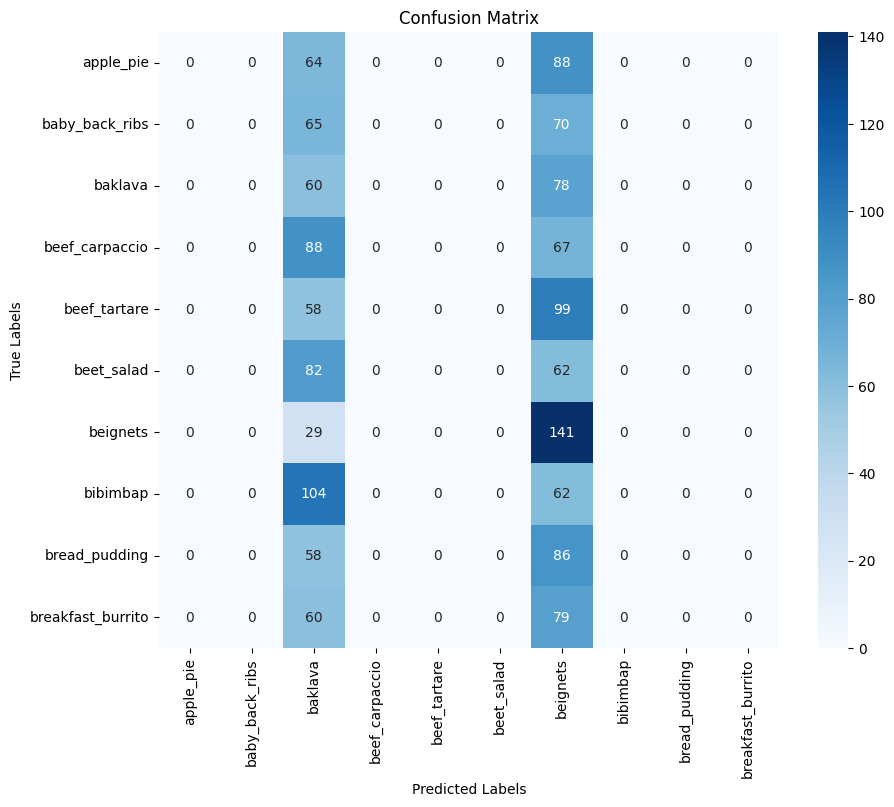

In [26]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()